Model Part 4

# GOAL


*   Hyper Tune parameters
*   Improve accuracy
*   Adding GAP 
*   Make changes based on GAP layer pobservations




# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [93]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


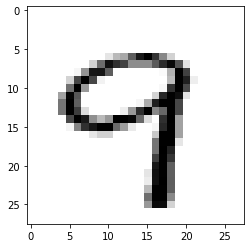

In [94]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

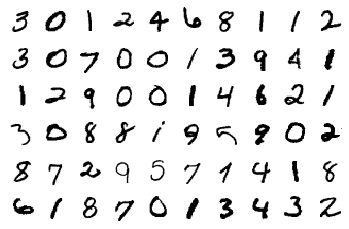

In [95]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
drop_val = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(drop_val)
        ) # output_size = 26
        # RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(drop_val)
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(drop_val)
        ) # output_size = 10

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(drop_val)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(drop_val),
            nn.ReLU()
        ) # output_size = 6

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(drop_val)
        ) # 
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # 

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1
        

        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool1(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [110]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
       BatchNorm2d-2           [-1, 10, 28, 28]              20
              ReLU-3           [-1, 10, 28, 28]               0
           Dropout-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 16, 26, 26]           1,440
       BatchNorm2d-6           [-1, 16, 26, 26]              32
              ReLU-7           [-1, 16, 26, 26]               0
           Dropout-8           [-1, 16, 26, 26]               0
            Conv2d-9           [-1, 10, 26, 26]             160
           Conv2d-10           [-1, 16, 24, 24]           1,440
      BatchNorm2d-11           [-1, 16, 24, 24]              32
             ReLU-12           [-1, 16, 24, 24]               0
          Dropout-13           [-1, 16, 24, 24]               0
        MaxPool2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [112]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.08859741687774658 Batch_id=468 Accuracy=82.33: 100%|██████████| 469/469 [00:16<00:00, 29.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1315, Accuracy: 9698/10000 (96.98%)

EPOCH: 1


Loss=0.10123145580291748 Batch_id=468 Accuracy=97.05: 100%|██████████| 469/469 [00:15<00:00, 29.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0654, Accuracy: 9819/10000 (98.19%)

EPOCH: 2


Loss=0.06820870190858841 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:15<00:00, 29.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0566, Accuracy: 9830/10000 (98.30%)

EPOCH: 3


Loss=0.021509749814867973 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:15<00:00, 29.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0496, Accuracy: 9862/10000 (98.62%)

EPOCH: 4


Loss=0.04367488622665405 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:15<00:00, 36.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0441, Accuracy: 9863/10000 (98.63%)

EPOCH: 5


Loss=0.00892135500907898 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:15<00:00, 29.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0398, Accuracy: 9885/10000 (98.85%)

EPOCH: 6


Loss=0.023882100358605385 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:15<00:00, 30.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9916/10000 (99.16%)

EPOCH: 7


Loss=0.027126984670758247 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:15<00:00, 30.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9914/10000 (99.14%)

EPOCH: 8


Loss=0.018618732690811157 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:15<00:00, 30.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9913/10000 (99.13%)

EPOCH: 9


Loss=0.021862223744392395 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:15<00:00, 30.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9905/10000 (99.05%)

EPOCH: 10


Loss=0.007282341364771128 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:15<00:00, 30.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9907/10000 (99.07%)

EPOCH: 11


Loss=0.047864049673080444 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:15<00:00, 30.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9929/10000 (99.29%)

EPOCH: 12


Loss=0.016352593898773193 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:15<00:00, 30.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9929/10000 (99.29%)

EPOCH: 13


Loss=0.020943231880664825 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:15<00:00, 38.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9922/10000 (99.22%)

EPOCH: 14


Loss=0.01145459245890379 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:15<00:00, 30.51it/s]



Test set: Average loss: 0.0250, Accuracy: 9926/10000 (99.26%)



Text(0.5, 1.0, 'Test Accuracy')

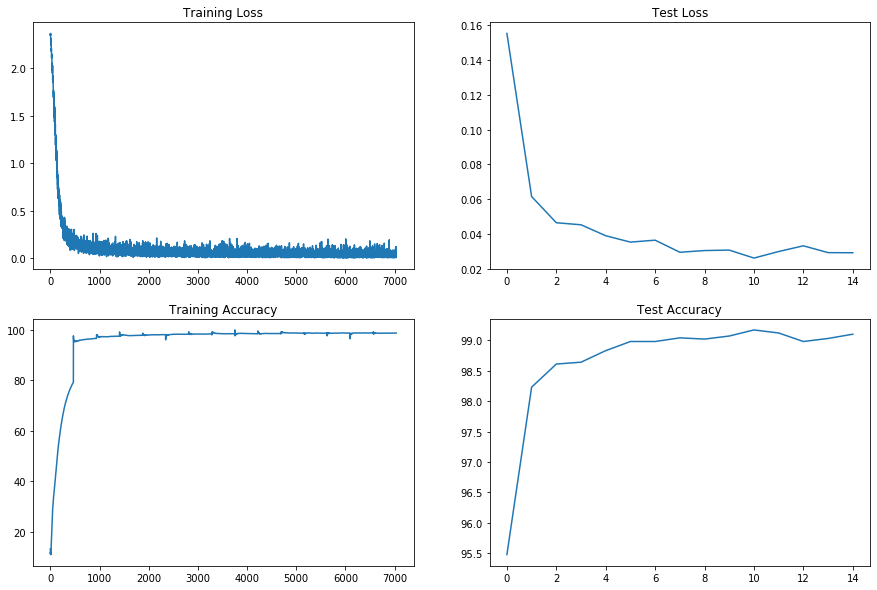

In [100]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [0]:
1)Changes made

a.Added gap instead of final convolution layer.

b.Avoiding code 7 (noted observations)

c.Added one more layer after GAP to improve accuracy.


3)Observations

a.Parameters reduced to 6k

b.Accuracy reduced to 98.83%

c.GAP seems to have reduced the gap between training and test accuracy very well. Final epoch was 98.83 (both train and test)


4)Part 3.2

a.Accuracy is close but we are still not getting to go above 99%

b.Training acc – 98.74%

c.Test acc- 98.88%
